In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2

!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/drive/MyDrive/Dataset_Covid/COVID-19_Radiography_Dataset'

In [7]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 14814 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.


In [8]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [9]:
from tensorflow.keras.applications import DenseNet201

In [10]:
def create_model():
    
    denseNet_model = DenseNet201(input_shape=(224,224,3), weights='imagenet', include_top=False)
    denseNet_model.trainable = False
    
    flatten = Flatten()(denseNet_model.layers[-1].output)
    fc = Dense(units=512, activation='relu')(flatten)
    dropout = Dropout(0.35)(fc)
    output = Dense(4, activation='softmax')(dropout)
   
    DenseNet201_MODEL = Model(inputs=denseNet_model.input, outputs=output)
    
    DenseNet201_MODEL.summary()
    
    return DenseNet201_MODEL


DenseNet201_MODEL = create_model()

74850304/74836368 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [11]:
DenseNet201_MODEL.compile(optimizer= tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])

In [12]:
#For avoiding overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [13]:
DenseNet201_MODEL.compile(optimizer= Adam(learning_rate = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = DenseNet201_MODEL.fit_generator(training_set, validation_data = valid_set, epochs=100, verbose=1, callbacks=[early])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/100
232/232 [==============================] - 277s 1s/step - loss: 2.3737 - accuracy: 0.7812 - precision: 0.8058 - recall: 0.7433 - val_loss: 0.3749 - val_accuracy: 0.8738 - val_precision: 0.9013 - val_recall: 0.8329
Epoch 2/100
232/232 [==============================] - 243s 1s/step - loss: 0.4136 - accuracy: 0.8502 - precision: 0.8710 - recall: 0.8219 - val_loss: 0.3437 - val_accuracy: 0.8712 - val_precision: 0.8831 - val_recall: 0.8603
Epoch 3/100
232/232 [==============================] - 239s 1s/step - loss: 0.4045 - accuracy: 0.8509 - precision: 0.8719 - recall: 0.8260 - val_loss: 0.3111 - val_accuracy: 0.8816 - val_precision: 0.8950 - val_recall: 0.8665
Epoch 4/100
232/232 [==============================] - 240s 1s/step - loss: 0.3745 - accuracy: 0.8588 - precision: 0.8795 - recall: 0.8374 - val_loss: 0.2894 - val_accuracy: 0.8892 - val_precision: 0.9000 - val_recall: 0.8745
Epoch 5/100
232/232 [==============================] - 239s 1s/step - loss: 0.3484 - accuracy: 0

In [14]:
DenseNet201_MODEL.evaluate(test_set, verbose=1)


34/34 [==============================] - 12s 349ms/step - loss: 0.2506 - accuracy: 0.9141 - precision: 0.9183 - recall: 0.9070


[0.25055548548698425,
 0.9141104221343994,
 0.9182990789413452,
 0.9070315957069397]

In [15]:
DenseNet201_MODEL.save('DenseNet201_MODEL.h5')

In [16]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     #history2.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [17]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.7812204957008362, 0.8502092361450195, 0.8508843183517456, 0.8588497638702393, 0.8754556775093079, 0.8743081092834473, 0.8771432638168335, 0.8889563679695129, 0.8895639181137085, 0.8982043862342834, 0.8948967456817627, 0.8909814953804016, 0.8997569680213928, 0.8970568180084229, 0.8986093997955322, 0.8996894955635071, 0.9048197865486145, 0.9063048362731934, 0.8973268270492554, 0.9054948091506958, 0.9009045362472534]
validation accuracy:  [0.8738185167312622, 0.871219277381897, 0.8816162347793579, 0.889177680015564, 0.8924857974052429, 0.9050094485282898, 0.9019376039505005, 0.9059546589851379, 0.9135160446166992, 0.9021739363670349, 0.8861058354377747, 0.8991020917892456, 0.903827965259552, 0.9149338603019714, 0.9068998098373413, 0.910916805267334, 0.9144612550735474, 0.9149338603019714, 0.9128071665763855, 0.9057183265686035, 0.9125708937644958]
loss:  [2.3736822605133057, 0.41362860798835754, 0.40450072288513184, 0.37454724311828613, 0.34835195541381836, 0.344290286302566

Text(0.5, 1.0, 'Training and Validation Accuracy')

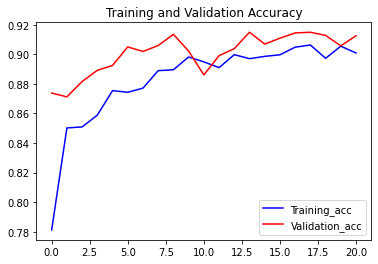

In [18]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

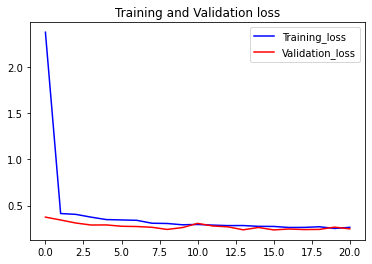

In [19]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

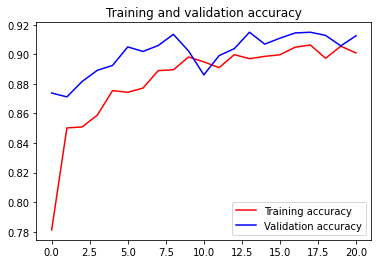

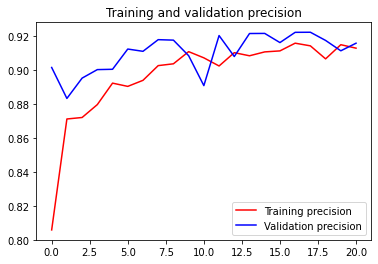

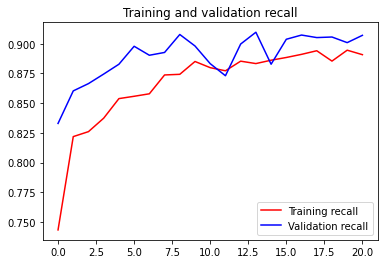

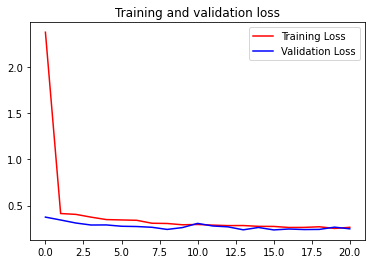

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
#model history
import pandas as pd
loss_df = pd.DataFrame(DenseNet201_MODEL.history.history)
loss_df

""


In [22]:
#prediction on test data
predictions = np.argmax(DenseNet201_MODEL.predict(test_set), axis = -1)

In [23]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       362
           1       0.93      0.82      0.87       602
           2       0.88      0.97      0.92      1020
           3       0.98      0.96      0.97       135

    accuracy                           0.91      2119
   macro avg       0.94      0.91      0.92      2119
weighted avg       0.92      0.91      0.91      2119



In [24]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[326  11  25   0]
 [  9 493 100   0]
 [  1  28 988   3]
 [  1   0   4 130]]
sensitivity: 0.9674
specificity: 0.9821


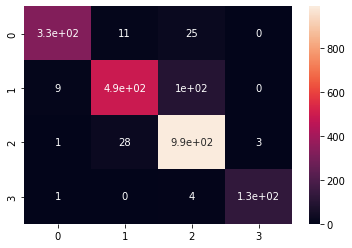

In [25]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))